In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [50]:
battery_data = pd.read_csv(r'/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')

In [51]:
display(battery_data.iloc[577])

Cycle_Index                   599.000
Discharge Time (s)           1545.880
Decrement 3.6-3.4V (s)        463.125
Max. Voltage Dischar. (V)       3.910
Min. Voltage Charg. (V)         3.744
Time at 4.15V (s)            2807.250
Time constant current (s)    3752.000
Charging time (s)            8415.620
RUL                           514.000
Name: 577, dtype: float64

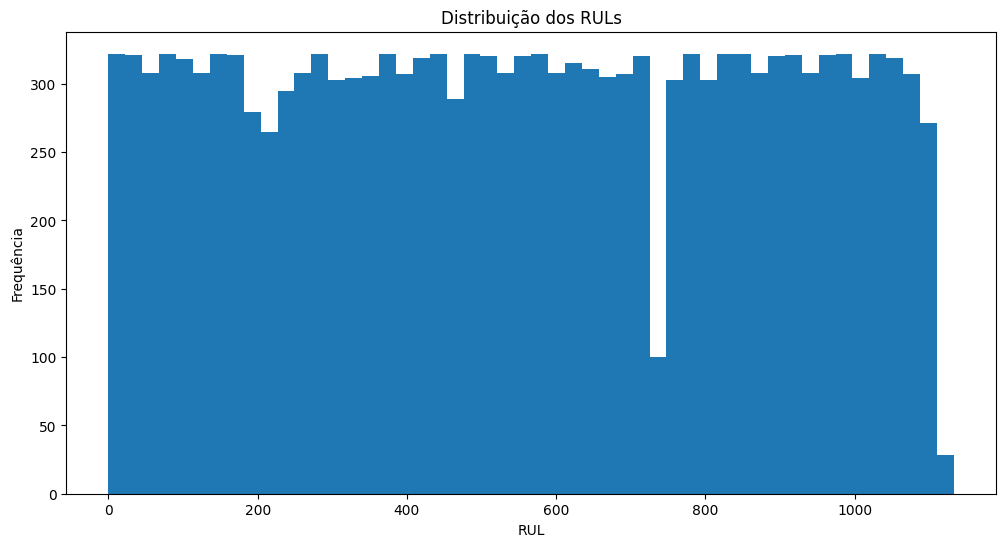


Estatísticas básicas do RUL:
count    15064.000000
mean       554.194172
std        322.434514
min          0.000000
25%        277.000000
50%        551.000000
75%        839.000000
max       1133.000000
Name: RUL, dtype: float64

Quantidade de amostras por faixa de RUL:
RUL_faixa
0-10         140
11-100      1259
101-500     5420
501-1000    6720
>1000       1511
Name: count, dtype: int64

Média das features por faixa de RUL:
           Discharge Time (s)  Decrement 3.6-3.4V (s)  \
RUL_faixa                                               
0-10               872.145286              218.319807   
11-100             939.101747              243.120661   
101-500           3043.328179             1193.247610   
501-1000          3853.463899             1002.798039   
>1000             9757.828776             2758.446782   

           Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  \
RUL_faixa                                                       
0-10                        3.769057 

In [52]:
# Análise exploratória do dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribuição dos RULs
plt.figure(figsize=(12, 6))
plt.hist(battery_data['RUL'], bins=50)
plt.title('Distribuição dos RULs')
plt.xlabel('RUL')
plt.ylabel('Frequência')
plt.show()

# 2. Estatísticas básicas
print("\nEstatísticas básicas do RUL:")
print(battery_data['RUL'].describe())

# 3. Contagem de amostras por faixas de RUL
bins = [0, 10, 100, 500, 1000, float('inf')]
labels = ['0-10', '11-100', '101-500', '501-1000', '>1000']
battery_data['RUL_faixa'] = pd.cut(battery_data['RUL'], bins=bins, labels=labels)
print("\nQuantidade de amostras por faixa de RUL:")
print(battery_data['RUL_faixa'].value_counts().sort_index())

# 4. Análise das features para diferentes RULs
features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)', 
           'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)', 
           'Charging time (s)']

# Valores médios das features por faixa de RUL
print("\nMédia das features por faixa de RUL:")
print(battery_data.groupby('RUL_faixa')[features].mean())

# 5. Análise do último ciclo (RUL = 0)
print("\nDados do último ciclo (RUL = 0):")
print(battery_data[battery_data['RUL'] == 0][features])

# 6. Correlação entre features e RUL
correlations = battery_data[features + ['RUL']].corr()['RUL'].sort_values()
print("\nCorrelação das features com RUL:")
print(correlations)

Análise Exploratória do Dataset de Vida Útil de Baterias

A análise do conjunto de dados de vida útil restante (RUL - Remaining Useful Life) de baterias revelou importantes características e desafios que explicam o desempenho atual do modelo preditivo. O dataset contém 15.064 registros, com valores de RUL variando de 0 a 1.133 ciclos, apresentando uma média de 554 ciclos e um desvio padrão de 322 ciclos.

Um dos aspectos mais críticos identificados é o significativo desbalanceamento na distribuição dos dados. A maioria das amostras está concentrada na faixa de RUL entre 501-1000 ciclos (6.720 amostras) e 101-500 ciclos (5.420 amostras). Em contraste, existem apenas 140 amostras para RULs muito baixos (0-10 ciclos) e 1.259 amostras para RULs entre 11-100 ciclos. Este desbalanceamento explica parcialmente por que o modelo tem dificuldade em fazer previsões precisas para baterias próximas ao fim de vida.

A análise de correlação entre as features e o RUL revelou que apenas duas variáveis apresentam correlações fortes: a tensão máxima de descarga (correlação positiva de 0,78) e a tensão mínima de carga (correlação negativa de -0,76). As demais features mostram correlações surpreendentemente baixas, com valores abaixo de 0,18, sugerindo que muitas das variáveis atualmente utilizadas podem não ser bons preditores do RUL.

Um problema particularmente preocupante foi identificado nos dados de fim de vida (RUL = 0). Estes registros apresentam valores anômalos em várias features, com medidas ordens de magnitude maiores que a média do dataset. Por exemplo, o tempo de descarga apresenta valores superiores a 670.000 segundos, quando a média para outras faixas de RUL está tipicamente abaixo de 10.000 segundos. Estas anomalias são provavelmente erros de medição ou registro e estão contribuindo significativamente para o alto erro nas previsões de fim de vida.

A análise das médias das features por faixa de RUL mostra tendências claras de degradação, mas também destaca a inconsistência dos dados para RULs baixos. Por exemplo, o tempo de descarga médio cai de 9.757 segundos para baterias novas (RUL > 1000) para apenas 872 segundos em baterias próximas ao fim de vida (RUL 0-10), uma redução que parece seguir um padrão lógico. No entanto, outras métricas mostram variações menos consistentes ou até contraditórias.
Para melhorar a qualidade das previsões, especialmente para RULs baixos, será necessário implementar várias medidas corretivas. Primeiro, é essencial realizar uma limpeza dos dados para remover ou corrigir as anomalias identificadas. Em seguida, técnicas de balanceamento de dados, como SMOTE (Synthetic Minority Over-sampling Technique), podem ser aplicadas para equilibrar a representação das diferentes faixas de RUL. Adicionalmente, novas features derivadas podem ser criadas para capturar melhor as relações entre as variáveis existentes e o processo de degradação da bateria.

Por fim, recomenda-se a implementação de uma estratégia de treinamento estratificada para garantir que todas as faixas de RUL sejam adequadamente representadas durante o treinamento do modelo. Estas modificações devem resultar em um modelo mais robusto e capaz de fazer previsões mais precisas ao longo de toda a vida útil da bateria, especialmente nos estados críticos próximos ao fim de vida.




Melhorando a qualidade do dataset

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def clean_dataset(df):
    print("Tamanho original do dataset:", len(df))
    
    # Calcular estatísticas para identificar outliers
    stats = df.describe()
    
    # Definir limites para cada feature usando o método IQR
    df_clean = df.copy()
    features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 
                'Time constant current (s)', 'Charging time (s)']
    
    for feature in features:
        Q1 = stats.loc['25%', feature]
        Q3 = stats.loc['75%', feature]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Aplicar filtro
        df_clean = df_clean[
            (df_clean[feature] >= lower_bound) & 
            (df_clean[feature] <= upper_bound)
        ]
    
    print("Tamanho após remoção de anomalias:", len(df_clean))
    return df_clean

def create_features(df):
    df_new = df.copy()
    
    # Features derivadas
    df_new['voltage_range'] = df_new['Max. Voltage Dischar. (V)'] - df_new['Min. Voltage Charg. (V)']
    df_new['charging_efficiency'] = df_new['Charging time (s)'] / df_new['Discharge Time (s)']
    df_new['voltage_decay_rate'] = df_new['Decrement 3.6-3.4V (s)'] / df_new['Discharge Time (s)']
    df_new['charging_speed'] = df_new['Time constant current (s)'] / df_new['Charging time (s)']
    
    # Remover features derivadas com valores infinitos ou NaN
    df_new = df_new.replace([np.inf, -np.inf], np.nan)
    df_new = df_new.dropna()
    
    return df_new

def balance_by_stratified_sampling(df):
    # Criar bins para RUL
    df['RUL_bin'] = pd.qcut(df['RUL'], q=10, labels=False)
    
    # Encontrar o tamanho da menor classe
    min_size = df.groupby('RUL_bin').size().min()
    max_size = df.groupby('RUL_bin').size().max()
    print("Tamanho da menor classe:", min_size)
    print("Tamanho da maior classe:", max_size)
    
    # Coletar amostras balanceadas
    balanced_samples = []
    for bin_label in df['RUL_bin'].unique():
        bin_data = df[df['RUL_bin'] == bin_label]
        balanced_samples.append(bin_data.sample(n=min_size, random_state=42))
    
    # Combinar todas as amostras
    df_balanced = pd.concat(balanced_samples)
    df_balanced = df_balanced.drop('RUL_bin', axis=1)
    
    print("\nTamanho do dataset após balanceamento:", len(df_balanced))
    return df_balanced

def prepare_data(df):
    # Definir features
    features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)',
                'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)',
                'Charging time (s)', 'voltage_range', 'charging_efficiency', 
                'voltage_decay_rate', 'charging_speed']
    
    X = df[features].values
    y = df['RUL'].values
    
    # Normalização
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    return X_scaled, y_scaled, scaler_X, scaler_y

def process_dataset(df):
    print("Iniciando processamento do dataset...")
    
    # 1. Limpeza
    print("\nEtapa 1: Limpeza dos dados")
    df_clean = clean_dataset(df)
    
    # 2. Feature Engineering
    print("\nEtapa 2: Criação de novas features")
    df_featured = create_features(df_clean)
    print("Novas features criadas:", 
          [col for col in df_featured.columns if col not in df_clean.columns])
    
    # 3. Balanceamento
    print("\nEtapa 3: Balanceamento do dataset")
    df_balanced = balance_by_stratified_sampling(df_featured)
    
    # 4. Preparação dos dados
    print("\nEtapa 4: Preparação dos dados")
    X_scaled, y_scaled, scaler_X, scaler_y = prepare_data(df_balanced)
    
    # 5. Divisão treino/teste
    print("\nEtapa 5: Divisão treino/teste")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Carregar e processar os dados
battery_data = pd.read_csv('/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')
X_train, X_test, y_train, y_test, scaler_X, scaler_y = process_dataset(battery_data)

# Verificar correlações
df_processed = create_features(clean_dataset(battery_data))
correlations = df_processed.corr()['RUL'].sort_values()
print("\nCorrelações com RUL (incluindo novas features):")
print(correlations)

# Salvar os dados processados
np.save('X_train_processed.npy', X_train)
np.save('X_test_processed.npy', X_test)
np.save('y_train_processed.npy', y_train)
np.save('y_test_processed.npy', y_test)

Iniciando processamento do dataset...

Etapa 1: Limpeza dos dados
Tamanho original do dataset: 15064
Tamanho após remoção de anomalias: 14615

Etapa 2: Criação de novas features
Novas features criadas: ['voltage_range', 'charging_efficiency', 'voltage_decay_rate', 'charging_speed']

Etapa 3: Balanceamento do dataset
Tamanho da menor classe: 1452
Tamanho da maior classe: 1473

Tamanho do dataset após balanceamento: 14520

Etapa 4: Preparação dos dados

Etapa 5: Divisão treino/teste
Tamanho original do dataset: 15064
Tamanho após remoção de anomalias: 14615

Correlações com RUL (incluindo novas features):
Cycle_Index                 -0.999752
charging_efficiency         -0.886996
Min. Voltage Charg. (V)     -0.806098
voltage_decay_rate           0.756862
Charging time (s)            0.897690
voltage_range                0.908241
Max. Voltage Dischar. (V)    0.957817
Decrement 3.6-3.4V (s)       0.964596
charging_speed               0.973543
Time constant current (s)    0.982676
Time at 4

Modelo corrigido 

In [54]:
df_processed.iloc[554]

Cycle_Index                   599.000000
Discharge Time (s)           1545.880000
Decrement 3.6-3.4V (s)        463.125000
Max. Voltage Dischar. (V)       3.910000
Min. Voltage Charg. (V)         3.744000
Time at 4.15V (s)            2807.250000
Time constant current (s)    3752.000000
Charging time (s)            8415.620000
RUL                           514.000000
voltage_range                   0.166000
charging_efficiency             5.443903
voltage_decay_rate              0.299587
charging_speed                  0.445838
Name: 577, dtype: float64

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import tempfile


# Configuração de seeds
torch.manual_seed(42)
np.random.seed(42)

Iniciando processamento do dataset...

Etapa 1: Limpeza dos dados
Tamanho original do dataset: 15064
Tamanho após remoção de anomalias: 14615

Etapa 2: Criação de novas features
Novas features criadas: ['voltage_range', 'charging_efficiency', 'voltage_decay_rate', 'charging_speed']

Etapa 3: Balanceamento do dataset

Tamanho do dataset após balanceamento: 14520

Etapa 4: Preparação dos dados

Etapa 5: Divisão treino/teste
Tamanho original do dataset: 15064
Tamanho após remoção de anomalias: 14615

Correlações com RUL (incluindo novas features):
Cycle_Index                 -0.999752
charging_efficiency         -0.886996
Min. Voltage Charg. (V)     -0.806098
voltage_decay_rate           0.756862
Charging time (s)            0.897690
voltage_range                0.908241
Max. Voltage Dischar. (V)    0.957817
Decrement 3.6-3.4V (s)       0.964596
charging_speed               0.973543
Time constant current (s)    0.982676
Time at 4.15V (s)            0.985559
Discharge Time (s)           0.

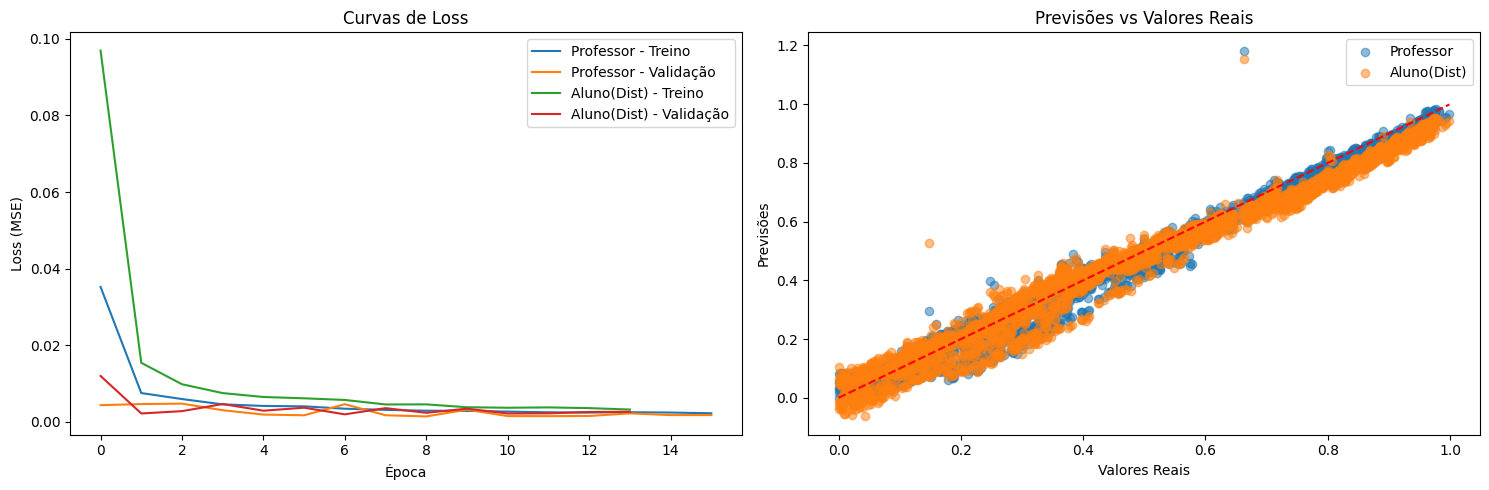


Tamanhos dos Modelos:
Professor: 584.51 KB
Aluno(Dist): 52.80 KB
Razão de Compressão: 11.07x


/home/romulo/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(



Tamanho do Aluno (Distilado + Quantizado): 35.20 KB
Redução de tamanho em relação ao Professor: 94.0%


In [56]:


# -----------------------
# 1) Pré-processamento
# -----------------------
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def clean_dataset(df):
    print("Tamanho original do dataset:", len(df))
    
    stats = df.describe()
    
    # Definir limites de IQR para algumas colunas
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Time constant current (s)', 
        'Charging time (s)'
    ]
    
    df_clean = df.copy()
    for feature in features:
        Q1 = stats.loc['25%', feature]
        Q3 = stats.loc['75%', feature]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[
            (df_clean[feature] >= lower_bound) &
            (df_clean[feature] <= upper_bound)
        ]
    
    print("Tamanho após remoção de anomalias:", len(df_clean))
    return df_clean

def create_features(df):
    df_new = df.copy()
    
    df_new['voltage_range'] = df_new['Max. Voltage Dischar. (V)'] - df_new['Min. Voltage Charg. (V)']
    df_new['charging_efficiency'] = df_new['Charging time (s)'] / df_new['Discharge Time (s)']
    df_new['voltage_decay_rate'] = df_new['Decrement 3.6-3.4V (s)'] / df_new['Discharge Time (s)']
    df_new['charging_speed'] = df_new['Time constant current (s)'] / df_new['Charging time (s)']
    
    # Tratar inf e NaN
    df_new = df_new.replace([np.inf, -np.inf], np.nan)
    df_new = df_new.dropna()
    
    return df_new

def balance_by_stratified_sampling(df):
    # Criar bins para RUL
    df['RUL_bin'] = pd.qcut(df['RUL'], q=10, labels=False)
    
    # Encontrar o tamanho da menor classe
    min_size = df.groupby('RUL_bin').size().min()
    
    # Amostragem balanceada
    balanced_samples = []
    for bin_label in df['RUL_bin'].unique():
        bin_data = df[df['RUL_bin'] == bin_label]
        balanced_samples.append(bin_data.sample(n=min_size, random_state=42))
    
    df_balanced = pd.concat(balanced_samples)
    df_balanced = df_balanced.drop('RUL_bin', axis=1)
    
    print("\nTamanho do dataset após balanceamento:", len(df_balanced))
    return df_balanced

def prepare_data(df):
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Max. Voltage Dischar. (V)',
        'Min. Voltage Charg. (V)', 
        'Time at 4.15V (s)', 
        'Time constant current (s)',
        'Charging time (s)', 
        'voltage_range', 
        'charging_efficiency',
        'voltage_decay_rate', 
        'charging_speed'
    ]
    
    X = df[features].values
    y = df['RUL'].values
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    return X_scaled, y_scaled, scaler_X, scaler_y

def process_dataset(df):
    print("Iniciando processamento do dataset...")
    
    print("\nEtapa 1: Limpeza dos dados")
    df_clean = clean_dataset(df)
    
    print("\nEtapa 2: Criação de novas features")
    df_featured = create_features(df_clean)
    print("Novas features criadas:", [col for col in df_featured.columns if col not in df_clean.columns])
    
    print("\nEtapa 3: Balanceamento do dataset")
    df_balanced = balance_by_stratified_sampling(df_featured)
    
    print("\nEtapa 4: Preparação dos dados")
    X_scaled, y_scaled, scaler_X, scaler_y = prepare_data(df_balanced)
    
    print("\nEtapa 5: Divisão treino/teste")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# --------------------------------------------------
# Carregar e processar os dados
# --------------------------------------------------
battery_data = pd.read_csv('/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')
X_train, X_test, y_train, y_test, scaler_X, scaler_y = process_dataset(battery_data)

import joblib
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# (Opcional) ver correlações
df_processed = create_features(clean_dataset(battery_data))
correlations = df_processed.corr()['RUL'].sort_values()
print("\nCorrelações com RUL (incluindo novas features):")
print(correlations)

# Salvar os dados processados
np.save('X_train_processed.npy', X_train)
np.save('X_test_processed.npy', X_test)
np.save('y_train_processed.npy', y_train)
np.save('y_test_processed.npy', y_test)


# -----------------------
# 2) Definição de Modelos
# -----------------------
import torch.quantization

class TeacherModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(TeacherModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, 
                            batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size*2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(hidden_size*2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        x = self.batch_norm(lstm_out)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size=48):
        super(StudentModel, self).__init__()
        # parâmetro que permite "ajustar" a importância de cada feature
        self.feature_weights = nn.Parameter(torch.ones(input_size))
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = x * self.feature_weights  # ajusta cada feature
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        x = self.batch_norm(lstm_out)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

# -----------------------
# 3) Funções de Treino/Avaliação
# -----------------------

class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
            self.counter = 0
            
    def restore(self, model):
        if self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            predictions.extend(outputs.numpy().flatten())
            targets.extend(target.numpy().flatten())
    return total_loss / len(dataloader), predictions, targets


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs,
                scheduler=None, early_stopping=None, warmup_epochs=3):
    """
    Treinamento 'padrão', usado aqui apenas para o Professor.
    """
    train_losses = []
    val_losses = []
    initial_lr = optimizer.param_groups[0]['lr']
    
    for epoch in range(epochs):
        # Learning rate warmup
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, _, _ = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if scheduler is not None and epoch >= warmup_epochs:
            scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}")
        
        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                early_stopping.restore(model)
                break
                
    return (train_losses, val_losses)


def train_student_with_distillation(student, teacher, train_loader, val_loader, 
                                    criterion, alpha, optimizer, epochs,
                                    scheduler=None, early_stopping=None, warmup_epochs=3):
    """
    Treinamento do Aluno com distilação do Professor:
    loss_final = alpha*MSE(Aluno, Rótulo) + (1-alpha)*MSE(Aluno, Professor)
    """
    train_losses = []
    val_losses = []
    initial_lr = optimizer.param_groups[0]['lr']

    # Colocar professor em modo de avaliação para pegar previsões fixas.
    teacher.eval()
    
    for epoch in range(epochs):
        # Learning rate warmup
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        student.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # Obter predições do professor (sem cálculo de gradiente)
            with torch.no_grad():
                teacher_pred = teacher(inputs)
            
            # Predição do aluno
            student_pred = student(inputs)
            
            # Perda supervisada normal
            loss_supervised = criterion(student_pred, targets)
            # Perda de distilação
            loss_distill = criterion(student_pred, teacher_pred)
            
            # Combina as duas perdas
            loss = alpha * loss_supervised + (1 - alpha) * loss_distill
            
            loss.backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, _, _ = evaluate_model(student, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if scheduler is not None and epoch >= warmup_epochs:
            scheduler.step(val_loss)
            
        print(f"[Distillation] Epoch {epoch+1}/{epochs} | "
              f"Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}")
        
        if early_stopping is not None:
            early_stopping(val_loss, student)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                early_stopping.restore(student)
                break
                
    return (train_losses, val_losses)


# -----------------------
# 4) Ciclo de Treinamento
# -----------------------
import os

# Converte para tensores e cria DataLoaders
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# 4.1) Treinar Professor (padrão)
input_size = X_train.shape[1]
criterion = nn.MSELoss()

teacher = TeacherModel(input_size)
teacher_optimizer = optim.Adam(teacher.parameters(), lr=0.0005)
teacher_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    teacher_optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
early_stopping_teacher = EarlyStopping(patience=7, restore_best_weights=True)

print("Treinando modelo Professor...\n")
teacher_losses = train_model(
    model=teacher,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=teacher_optimizer,
    epochs=50,
    scheduler=teacher_scheduler,
    early_stopping=early_stopping_teacher,
    warmup_epochs=3
)


# 4.2) Treinar Aluno com distilação do Professor
student = StudentModel(input_size)
student_optimizer = optim.Adam(student.parameters(), lr=0.0005)
student_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    student_optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
early_stopping_student = EarlyStopping(patience=7, restore_best_weights=True)

alpha = 0.7 # peso do aprendizado supervisionado vs. distilação
print(f"\nTreinando modelo Aluno com distilação (alpha={alpha})...\n")
student_losses = train_student_with_distillation(
    student=student,
    teacher=teacher,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    alpha=alpha,
    optimizer=student_optimizer,
    epochs=50,
    scheduler=student_scheduler,
    early_stopping=early_stopping_student,
    warmup_epochs=3
)

# -----------------------
# 5) Avaliação e Plot
# -----------------------
print("\nAvaliando modelos...")
teacher_loss, teacher_pred, teacher_true = evaluate_model(teacher, test_loader, criterion)
student_loss, student_pred, student_true = evaluate_model(student, test_loader, criterion)

print(f"Loss final do Professor: {teacher_loss:.4f}")
print(f"Loss final do Aluno (Distilado): {student_loss:.4f}")

plt.figure(figsize=(15, 5))

# (5.1) Plot das curvas de Loss
plt.subplot(1, 2, 1)
plt.plot(teacher_losses[0], label='Professor - Treino')
plt.plot(teacher_losses[1], label='Professor - Validação')
plt.plot(student_losses[0], label='Aluno(Dist) - Treino')
plt.plot(student_losses[1], label='Aluno(Dist) - Validação')
plt.title('Curvas de Loss')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()

# (5.2) Plot predições vs valores reais
plt.subplot(1, 2, 2)
plt.scatter(teacher_true, teacher_pred, alpha=0.5, label='Professor')
plt.scatter(student_true, student_pred, alpha=0.5, label='Aluno(Dist)')
plt.plot([min(teacher_true), max(teacher_true)], 
         [min(teacher_true), max(teacher_true)], 'r--')
plt.title('Previsões vs Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.legend()

plt.tight_layout()
plt.show()


# -----------------------
# 6) Comparação de Tamanho e Quantização 
# -----------------------
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_kb = (param_size + buffer_size) / 1024
    return size_kb

def get_quantized_model_disk_size(model):
    import tempfile
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        temp_name = tmp.name
    torch.save(model.state_dict(), temp_name)
    size_kb = os.path.getsize(temp_name) / 1024
    os.remove(temp_name)
    return size_kb

print("\nTamanhos dos Modelos:")
teacher_size = get_model_size(teacher)
student_size = get_model_size(student)
print(f"Professor: {teacher_size:.2f} KB")
print(f"Aluno(Dist): {student_size:.2f} KB")
print(f"Razão de Compressão: {teacher_size / student_size:.2f}x")

# Quantizar o Aluno Distilado
student.train()
student.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare_qat(student, inplace=True)

# Passe rápido de calibração (QAT)
calib_optimizer = optim.Adam(student.parameters(), lr=1e-4)
for epoch in range(2):
    for inputs, targets in train_loader:
        calib_optimizer.zero_grad()
        outputs = student(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        calib_optimizer.step()

student.eval()
torch.quantization.convert(student, inplace=True)

quant_student_size = get_quantized_model_disk_size(student)
print(f"\nTamanho do Aluno (Distilado + Quantizado): {quant_student_size:.2f} KB")
print(f"Redução de tamanho em relação ao Professor: "
      f"{100*(1 - quant_student_size/teacher_size):.1f}%")


In [57]:
def process_new_data_for_inference(df_new, scaler_X):
    """
    Aplica o mesmo pipeline de limpeza e feature engineering,
    mas NÃO faz balanceamento e NÃO refaz fit do scaler.
    
    Retorna: X_infer (numpy array escalonado)
    """
    # 1) (Opcional) Limpeza de outliers
    #    Se for viável e desejável remover outliers de dados reais,
    #    você pode chamar clean_dataset. 
    #    Mas cuidado: isso pode descartar linhas que poderiam ser legítimas.

    # df_clean = clean_dataset(df_new)
    
    # 2) Criação de features
    df_featured = create_features(df_new)
    # df_featured = create_features(df_clean)
    
    # 3) Montar array de features
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Max. Voltage Dischar. (V)',
        'Min. Voltage Charg. (V)', 
        'Time at 4.15V (s)', 
        'Time constant current (s)',
        'Charging time (s)', 
        'voltage_range', 
        'charging_efficiency', 
        'voltage_decay_rate', 
        'charging_speed'
    ]
    X_new = df_featured[features].values
    
    # 4) Escalonar (usando transform, NÃO fit_transform)
    X_infer = scaler_X.transform(X_new)
    
    return X_infer, df_featured  # df_featured



In [58]:
def predict_rul_in_pipeline(df_novo):
    """
    Pipeline completo de inferência em dados 'df_novo'
    (sem reamostragem, mas com as mesmas transformations).
    Retorna as predições de RUL e o DF resultante.
    """
    # 1) Carregar scalers e modelo
    scaler_X = joblib.load("scaler_X.pkl")
    scaler_y = joblib.load("scaler_y.pkl")
    
    # 2) Carregar e inicializar o modelo
    input_size = 11  # deve ser o mesmo do treino
    model = StudentModel(input_size=input_size)
    state_dict = torch.load("/home/romulo/Documentos/PDC_codes/student_model.pth")
    model.load_state_dict(state_dict)
    model.eval()
    
    # 3) Aplicar pipeline de pré-processamento (menos balanceamento)
    X_infer, df_feat = process_new_data_for_inference(df_novo, scaler_X)
    
    # 4) Converter X_infer para tensor
    X_tensor = torch.FloatTensor(X_infer)
    
    # 5) Fazer a predição
    with torch.no_grad():
        pred_scaled = model(X_tensor)
    
    # 6) Desscalonar RUL
    pred_np = pred_scaled.numpy().reshape(-1, 1)
    rul_pred = scaler_y.inverse_transform(pred_np).ravel()
    rul_pred = np.clip(rul_pred, a_min=0, a_max=None)
    
    # 7) Adicionar a coluna de predição ao DataFrame
    df_feat["RUL_pred"] = rul_pred
    
    return rul_pred, df_feat


if __name__ == "__main__":
    # (devem conter as colunas mínimas: Discharge Time (s), Decrement 3.6-3.4V (s), etc.)
#     df_novo = pd.DataFrame({
#     "Cycle_Index": [362, 610],
#     "Discharge Time (s)": [5500, 5800],
#     "Decrement 3.6-3.4V (s)": [950, 1000],
#     "Max. Voltage Dischar. (V)": [4.07, 4.05],
#     "Min. Voltage Charg. (V)": [3.35, 3.33],
#     "Time at 4.15V (s)": [2300, 2100],
#     "Time constant current (s)": [3600, 3700],
#     "Charging time (s)": [6000, 6150],
#     # RUL apenas para referência 
#     "RUL": [750, 700]
# })

#     df_novo = pd.DataFrame({
#     "Cycle_Index": [28.000000],
#     "Discharge Time (s)": [2234.380000],
#     "Decrement 3.6-3.4V (s)": [852.000000],
#     "Max. Voltage Dischar. (V)": [4.045000],
#     "Min. Voltage Charg. (V)": [3.378000],
#     "Time at 4.15V (s)": [5118.368000],
#     "Time constant current (s)": [6091.360000],
#     "Charging time (s)": [9176.380000],
#     "RUL": [1085.000000]
# })
    
    df_novo = pd.DataFrame({
    "Cycle_Index": [599.000000],
    "Discharge Time (s)": [1545.880000],
    "Decrement 3.6-3.4V (s)": [463.125000],
    "Max. Voltage Dischar. (V)": [3.910000],
    "Min. Voltage Charg. (V)": [3.744000],
    "Time at 4.15V (s)": [2807.250000],
    "Time constant current (s)": [3752.000000],
    "Charging time (s)": [8415.620000],
    "RUL": [514.000000]
})


    # Prever
    rul_pred, df_pred = predict_rul_in_pipeline(df_novo)
    # rul_pred_clamped = np.clip(rul_pred, 0, 1112)  # Dados fictícios não representativos com realação aos dados de treino


    print("Predições de RUL:", rul_pred)
    print(df_pred)


Predições de RUL: [538.4916]
   Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
0        599.0             1545.88                 463.125   

   Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
0                       3.91                    3.744            2807.25   

   Time constant current (s)  Charging time (s)    RUL  voltage_range  \
0                     3752.0            8415.62  514.0          0.166   

   charging_efficiency  voltage_decay_rate  charging_speed    RUL_pred  
0             5.443903            0.299587        0.445838  538.491577  


/tmp/ipykernel_299145/1226136403.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/home/romulo/Documentos/PDC_codes/student_model.pth")
